# Moment Based Model
This model is better estimating parameters in biological systems mainly affected by intrinsic noise. It computes the second order moment differential equations of the system to approximate some population statistics as mean and variance of the gene expression. In this way, it is possible to estimate deterministically a system which was simulated in a stochastic way. This model is applied together to a KLD minimization as a loss function.

In [1]:
#required libraries
import simsysbio as s2b
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

**Loads data**. The data is loaded to save time computing a new whole population.

In [2]:
uObs = np.load("CMEmean.npy")
sdObs = np.load("CMEsd.npy")
tog = np.load("tog.npy")
hog = np.load("hog.npy")

**Plots data used to perform estimation**

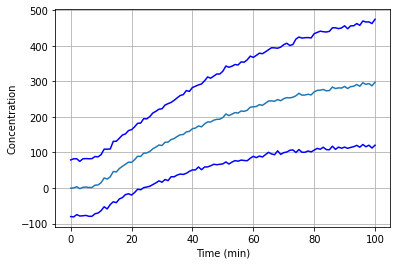

In [3]:
plt.figure()
plt.plot(tog, uObs)
plt.plot(tog, uObs+sdObs, 'b')
plt.plot(tog, uObs-sdObs, 'b')
plt.xlabel('Time (min)')
plt.ylabel('Concentration')
plt.grid()
plt.show()

In [4]:
#molecular species
especies = ['mRNA', 'Protein']

#Stoichiometric matrices
reactivos = np.array([[0, 1, 1, 0],[0, 0, 0, 1]])
productos = np.array([[1, 0, 1, 0],[0, 0, 1, 0]])

#kinetic parameters names
parametros = ['c1', 'c2', 'c3', 'c4']

#system input
entrada = 'u'
idxR = 0

#computes simbolic system of differential equations
ecuaciones, variables = s2b.simbMoments(especies, reactivos, productos, parametros,
                                   inputN=entrada)

#creates .py file containing the system of equation upon second moment order
s2b.model2MDefiner(variables["nameVar"][1:], ecuaciones, variables["pars"])

#kinetic parameters 
parsValues = [4.0, 0.010, 1.0, 0.006]

#initial concentrations
sp0 = np.zeros(len(variables["nameVar"]) - 1)

#initial noise measurement guess
noise = np.array([0,0])

#regressor variables
regressor = {
        "ODEs": ecuaciones,
        "matrizR": reactivos,
        "matrizP": productos,
        "vPars": parsValues,
        "idxR": idxR,
        "inpU": hog,
        "Vtime": tog,
        "species0":sp0,
        "noise":noise,
        "uObs":uObs,
        "sdObs":sdObs
        }
regressor.update(variables)

**Inferring process**

In [5]:
#initial parameter guesses
beta0 = np.array([3.0, 0.02, 0.9, 0.01, 10.0, 0.1])

#finds moments
ODE2M, vars2M = s2b.simbMoments(especies, reactivos, productos, parametros,
                                   inputN=entrada, indexU=idxR)

sp0 = np.concatenate((regressor["species0"], np.zeros(len(ODE2M) - len(regressor["species"]))))

regressor2 = {
        "ODEs": ODE2M,
        "regressor":regressor,
        "inpU": hog,
        "Vtime": tog,
        "species0":sp0,
        "meanCell":uObs,
        "sdCell":sdObs
        }
regressor2.update(vars2M)

idx2M = list(map(str, regressor2["species"]))
idx2M = idx2M.index(especies[-1] + '**2')
regressor2["idx2M"] = idx2M
regressor2["errPars"] = errAB

In [6]:
#defines estimation function
def KLDmeasure(uObs, sdObs, uM, sdM):
    kld = np.log(sdM/sdObs) + ((sdObs**2 + (uObs-uM)**2)/(2*sdM**2)) - 1/2
    return np.mean(kld)

def KLDmomentsWrap(Allpars, regressor):
    
    uM, sdM = s2b.solve2M(Allpars[:-2], Allpars[-2:], regressor)
    
    mcKLD = KLDmeasure(regressor["uObs"], regressor["sdObs"], uM, sdM)
    print(mcKLD)
    return mcKLD

In [7]:
#performs estimation
options = {"maxiter":150} #100 iterations for better estimation
minimum = minimize(KLDmomentsWrap, beta0, args=(regressor,), options=options)
betacal = minimum.x

4.985090970933189
4.9850909432091015
4.985093296424974
4.985090834797463
4.985094256310506
4.985090962465742
4.985090876397147
4.985090970933189
37.761113020697366
37.761113020697366
37.761113032208875
37.76111290348884
37.76111303160169
37.761112469443084
37.761113015420605
37.76111298058298
13.730489504770917
13.730489504770917
13.730489521917754
13.730489034210196
13.730489512112788
13.730489230922867
13.730489498268474
13.730489395631684
6.19190436681466
6.19190436681466
6.191904378301991
6.191903723280739
6.191904371785301
6.191903967748359
6.191904359442313
6.191904292412981
3.365725116729309
3.365725116729309
3.365725117858745
3.3657247700446886
3.3657251079433146
3.365724667200817
3.365725108923155
3.3657250723898353
6.993980283525716
6.993980283525716
6.9939802857530236
6.993980257835507
6.993980288491924
6.993979664271217
6.993980278197337
6.993980277515381
3.37321659707083
3.37321659707083
3.373216598497348
3.373216457563949
3.3732165935268097
3.3732159604302545
3.3732165898

0.025611384070516267
0.025611384068031793
0.025611383780382795
0.025611384073822543
0.025611385289200345
0.025611384066747546
0.02561138419610329
0.025521917733062865
0.025521917733062865
0.025521917737194436
0.025521917230602896
0.025521917744528902
0.025521918855961726
0.02552191772921416
0.025521917921880667
0.025356264905818778
0.025356264905818778
0.025356264916051446
0.025356264675289356
0.0253562649263101
0.02535626594517658
0.02535626490178623
0.025356265186317534
0.025049029269903423
0.025049029269903423
0.025049029273518205
0.02504903193460778
0.025049029287020283
0.025049030459506478
0.02504902926538802
0.02504902966507218
0.02453491956888087
0.02453491956888087
0.02453491949439796
0.024534938173973234
0.024534919479108838
0.024534922452097922
0.02453491956282061
0.02453492000525238
0.025634333535180503
0.025634333535180503
0.02563433311004683
0.025634422567948036
0.02563433267083418
0.02563434630411382
0.02563433352401882
0.02563433335956361
0.02428016270923073
0.0242801627

0.0030601128638306795
0.0030601115765372033
0.003060111638888943
0.003085469095930098
0.003085469095930098
0.0030854690943887997
0.0030854698267508275
0.00308546886182035
0.003085470421877008
0.0030854690970044917
0.0030854692009501775
0.0030394572043980724
0.0030394572043980724
0.003039457208287401
0.003039451910788772
0.003039457762513957
0.0030394544694371996
0.003039457205464658
0.003039457264380271
0.0030318741855224008
0.0030318741855224008
0.0030318741860933325
0.003031871546220393
0.0030318742376715065
0.003031873324568391
0.0030318741864364895
0.0030318741906255574
0.0030241477505028713
0.0030241477505028713
0.003024147750919294
0.0030241456996145835
0.003024147775218786
0.0030241472570028175
0.0030241477513261762
0.003024147733427396
0.003009779710940834
0.003009779710940834
0.0030097797112493083
0.0030097781293752057
0.003009779716009339
0.003009779487920295
0.0030097797116665796
0.0030097796715373914
0.0029830765982466726
0.0029830765982466726
0.0029830765986672393
0.002983

0.0026246084686096178
0.0026246068194036897
0.0026246087557533107
0.0026246071703412656
0.0026246071497658236
0.0026201399159629705
0.0026201399159629705
0.002620139914075068
0.0026201409621081245
0.002620139654354008
0.002620141244448942
0.0026201399157722892
0.0026201399015914027
0.0026133136714402943
0.0026133136714402943
0.0026133136691941757
0.0026133150779298286
0.002613313380073833
0.00261331540194754
0.002613313671326338
0.002613313651009258
0.0026050713672402313
0.0026050713672402313
0.002605071367378266
0.0026050717954936484
0.002605071331935662
0.0026050720948393893
0.002605071367417239
0.0026050713612371136
0.0026275928363740145
0.0026275928363740145
0.0026275928250436807
0.002627599006322737
0.0026275917418288426
0.002627599416795244
0.0026275928362518314
0.0026275927311800716
0.002601501528496318
0.002601501528496318
0.002601501526642164
0.0026015029990081994
0.002601501292842455
0.002601503349994958
0.002601501528638292
0.0026015015039738674
0.00259566262719955
0.0025956

In [8]:
print("Infered kinetic parameters", betacal[:-2])
print("Infered noise parameters", betacal[-2:])

Infered kinetic parameters [1.23525832e+01 1.00148834e-02 2.46083542e-01 3.06634792e-03]
Infered noise parameters [74.06639628  0.25374696]


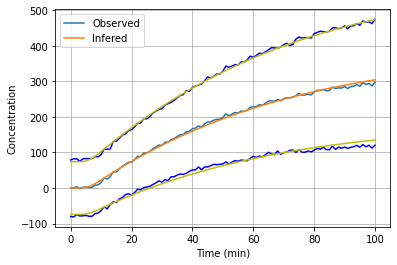

In [9]:
#simulates output with infered parameters
uMif, sdMif = s2b.solve2M(betacal[:-2], betacal[-2:], regressor)

#plot population curves
plt.figure()
plt.plot(tog, uObs, label="Observed")
plt.plot(tog, uObs+sdObs, 'b')
plt.plot(tog, uObs-sdObs, 'b')
plt.plot(tog, uMif, label="Infered")
plt.plot(tog, uMif+sdMif, 'y')
plt.plot(tog, uMif-sdMif, 'y')
plt.xlabel('Time (min)')
plt.ylabel('Concentration')
plt.legend(loc="best")
plt.grid()
plt.show()